## Data loading

To work with any kind of data we first have to load it. For this we use a dataloader that reads the images as well as their labels and transforms them into pytorch readable tensors.

In [1]:
import pathlib

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [2]:
class RSiMCCDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.transform = transform
        # get images
        image_files = [x.resolve() for x in pathlib.Path(".").glob('data/*/*')]
        # Image.open() has a bug, this is a workaround
        self.images=[read_image(str(p)) for p in image_files] 
        # get labels from image path
        labels = [x.parts[-2] for x in image_files]
        self.classes = sorted(list(set(labels)))
        self.labels = [self.label_to_tensor(lbl) for lbl in labels]

        assert len(self.labels) == len(self.images), f"Found {len(self.labels)} labels and {len(self.images)} images"

    def label_to_tensor(self, lbl):
        """
        Converts the string label to a one-hot tensor where every entry is zero except the label which is one.
        
        """
        assert lbl in self.classes, f"Class {lbl} not a valid class (valid classes: {self.classes})"
        t = torch.zeros(len(self.classes))
        t[self.classes.index(lbl)] = 1
        return t

    def tensor_to_label(self, t):
        """
        Returns the classname in string format
        """
        assert len(t.shape) == 1, f"Can only convert 1-dimensional tensors (shape of tensor: {t.shape})"
        assert len(t) == len(self.classes), f"Lenght of tensor ({len(t)}) does not match number of classes ({len(self.classes)})"
        return self.classes[t.argmax()]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx].float()/255
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

## Examples
Now lets load the dataset and look at some examples by just randomly loading the images and their labels

In [3]:
dataset = RSiMCCDataset()

In [4]:
print(f"The dataset consists of {len(dataset)} RGB images of shape {dataset.images[0].shape} labeled in {dataset.labels[0].shape[0]} classes which are " + ', '.join(dataset.classes))

The dataset consists of 11519 RGB images of shape torch.Size([3, 64, 64]) labeled in 10 classes which are AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake


In [118]:
dataset.__getitem__(0)[1].shape

torch.Size([10])

In [114]:
# creating the encoder
def get_encoder(latent_dim=32):
    base_encoder = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=12, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),


        nn.Conv2d(64, 64, kernel_size=8, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 64, kernel_size=6, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),


        nn.Conv2d(64, 64, kernel_size=5, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 64, kernel_size=5, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 64, kernel_size=5, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, latent_dim, kernel_size=4, padding=2),
        nn.BatchNorm2d(latent_dim),
        nn.ReLU(inplace=True),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
    )
    return base_encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        # inputs (N,3,64,64)

        # Classical processing of images with pattern recognition
        # Follows ResNET architecture: Conv2d -> BN -> ReLU (-> MaxPool)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=15, padding=7)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        # no pooling in 1st step
        

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=11, padding=5)
        self.bn2   = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=9, padding=4)
        self.bn3   = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        # no pooling in 3rd step

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=9, padding=4)
        self.bn4   = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=9, padding=4)
        self.bn5   = nn.BatchNorm2d(64)
        self.relu5 = nn.ReLU()
        # no pooling in 5th step

        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=9, padding=4)
        self.bn6   = nn.BatchNorm2d(64)
        self.relu6 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self.conv7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=9, padding=4)
        self.bn7   = nn.BatchNorm2d(64)
        self.relu7 = nn.ReLU()

        # A FINIR !
        self.drop8 = nn.Dropout(p=0.05)
        self.lin8  = nn.Linear(64*8*8, latent_dim) # adapt here!
        
    def forward(self, x):        

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = x + self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x + self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = x + self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = x + self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)

        x = x + self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pool6(x)

        x = x + self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)

        # outputs (None, 8, 4, 4)
        x = self.drop8(x)
        x = self.lin8(x.view(-1, 64*8*8))  # adapt here!
        return x

def get_encoder(latent_dim=32):
    return Encoder(latent_dim)

In [6]:
## Creating the projection head
def get_projection_head(latent_dim=32, nb_features=32):
    projection_head = nn.Sequential(
        nn.Linear(latent_dim, nb_features),
        nn.BatchNorm1d(nb_features),
        nn.ReLU(),
    )
    return projection_head

In [105]:
from torchinfo import summary # sends the model to the gpu ?

encoder = get_encoder()
dummy_input = torch.randn(42, 3, 64, 64)
print(f"output shape: {encoder(dummy_input).shape}")

""" import torchlens as tl
model_history = tl.log_forward_pass(encoder, dummy_input, layers_to_save='all', vis_opt='rolled')
print(model_history) """
summary(encoder, input_size=(42, 3, 64, 64))

output shape: torch.Size([42, 32])


Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [42, 32]                  --
├─Conv2d: 1-1                            [42, 64, 64, 64]          43,264
├─BatchNorm2d: 1-2                       [42, 64, 64, 64]          128
├─ReLU: 1-3                              [42, 64, 64, 64]          --
├─Conv2d: 1-4                            [42, 64, 64, 64]          495,680
├─BatchNorm2d: 1-5                       [42, 64, 64, 64]          128
├─ReLU: 1-6                              [42, 64, 64, 64]          --
├─MaxPool2d: 1-7                         [42, 64, 32, 32]          --
├─Conv2d: 1-8                            [42, 64, 32, 32]          331,840
├─BatchNorm2d: 1-9                       [42, 64, 32, 32]          128
├─ReLU: 1-10                             [42, 64, 32, 32]          --
├─Conv2d: 1-11                           [42, 64, 32, 32]          331,840
├─BatchNorm2d: 1-12                      [42, 64, 32, 32]      

In [106]:
from torchvision import transforms 

def augment(x):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        # transforms.RandomRotation([0,90]),
        transforms.RandomApply([
            # transforms.ColorJitter(brightness=0.1, contrast=0.3, saturation=0.3, hue=0.2),
            transforms.ColorJitter(hue=0.1),
            transforms.ColorJitter(saturation=0.2),
            transforms.ColorJitter(contrast=0.1),
            transforms.ColorJitter(brightness=0.2),
            transforms.RandomGrayscale(p=0.4),
            transforms.RandomAdjustSharpness(sharpness_factor=0.5),
            # transforms.RandomResizedCrop(size=40, scale=(0.8, 0.8)),
            # transforms.GaussianBlur(kernel_size=1, sigma=(0.1, 2.0)),
        ], p=0.8),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    x = transform(x)
    return x

In [107]:
class ViewTransform(object):
    def __call__(self, x):
        return (augment(x),augment(x))


dataset = RSiMCCDataset()
print(f"The dataset consists of {len(dataset)} RGB images of shape {dataset.images[0].shape} labeled in {dataset.labels[0].shape[0]} classes which are " + ', '.join(dataset.classes))
dataset.transform = ViewTransform()

print(f"The augmented dataset consists of {len(dataset)} tuples of RGB images (two transformations of each)")

The dataset consists of 11519 RGB images of shape torch.Size([3, 64, 64]) labeled in 10 classes which are AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake
The augmented dataset consists of 11519 tuples of RGB images (two transformations of each)


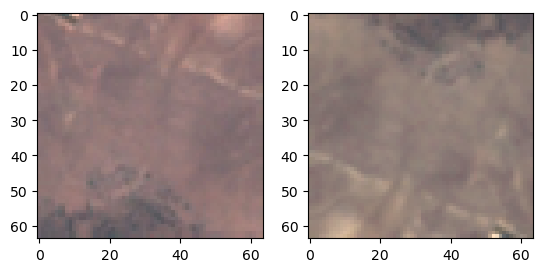

In [108]:
import matplotlib.pyplot as plt
r = torch.randint(0, len(dataset), (1,))
images = dataset.__getitem__(r)[0]
# plot the images side by side
fig, axs = plt.subplots(1, 2)
axs[0].imshow(images[0].permute(1, 2, 0))
axs[1].imshow(images[1].permute(1, 2, 0))
plt.show()

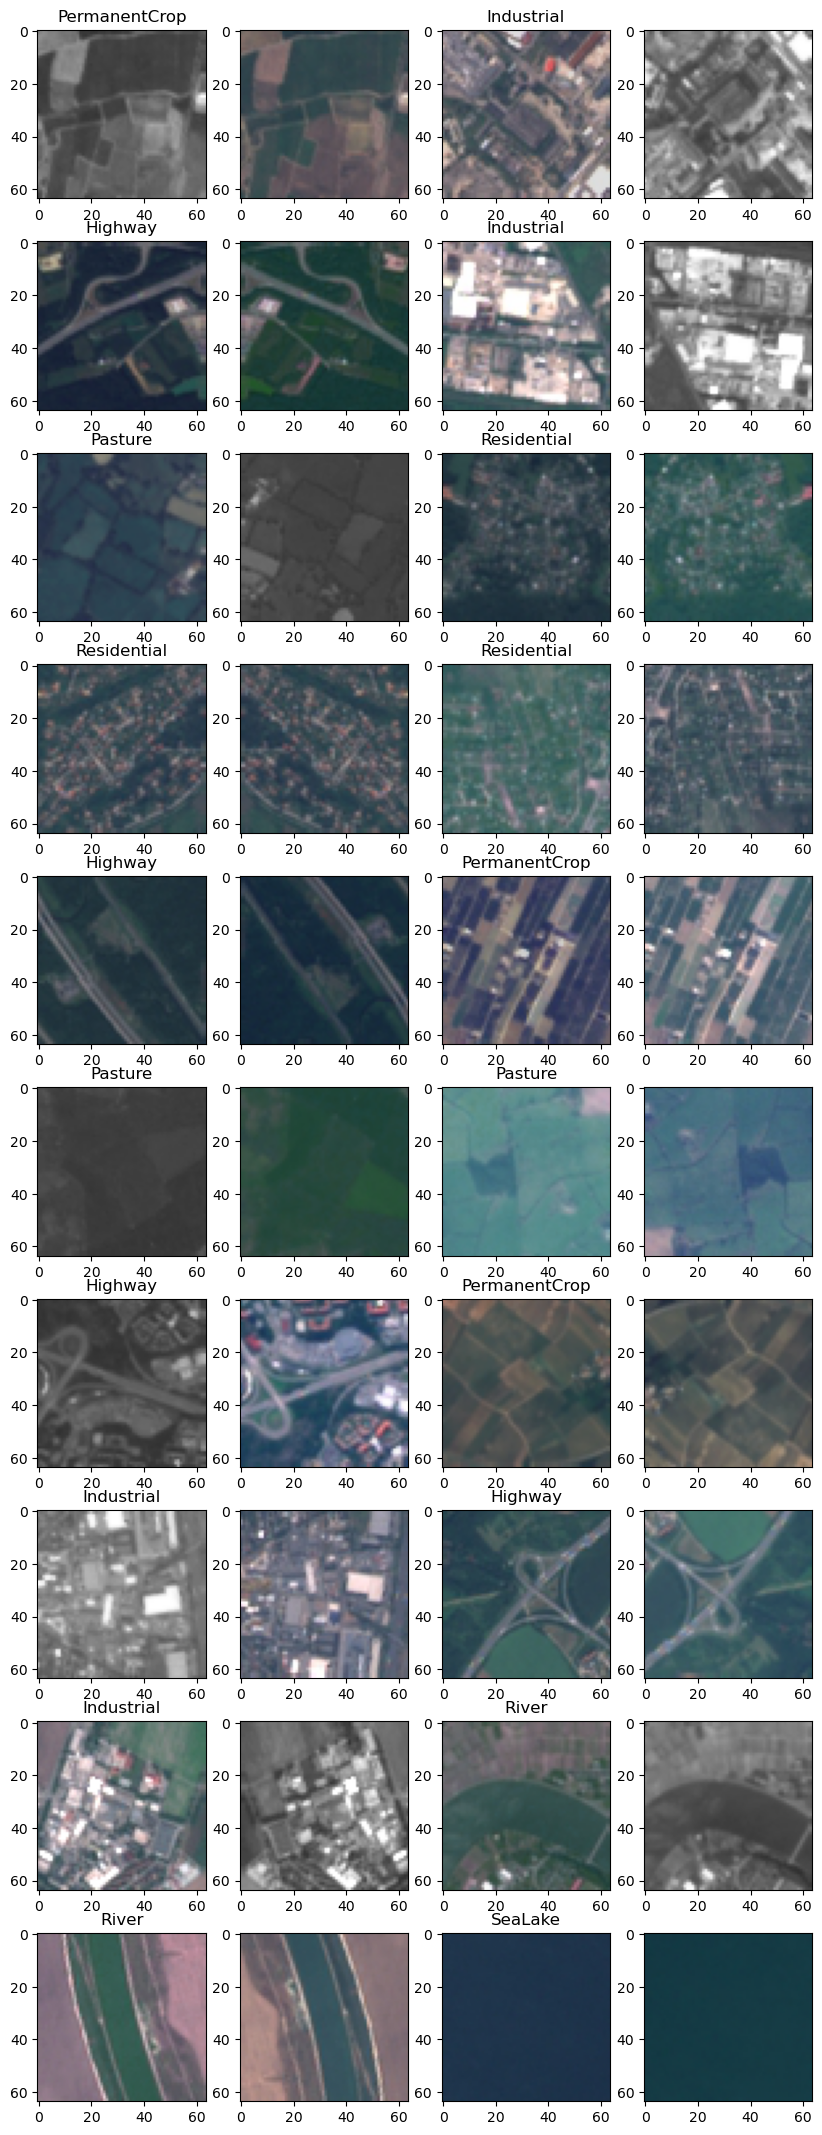

In [20]:
fig, axs = plt.subplots(10, 4, figsize=(10, 27))

# loop through each subplot and plot 2 pairs of images per row
r = torch.randint(0, len(dataset), (20,))
for i in range(10):
    images1 = dataset.__getitem__(r[i])
    images2 = dataset.__getitem__(r[i+10])
    axs[i,0].imshow(images1[0][0].permute(1, 2, 0))
    axs[i,1].imshow(images1[0][1].permute(1, 2, 0))
    axs[i,2].imshow(images2[0][0].permute(1, 2, 0))
    axs[i,3].imshow(images2[0][1].permute(1, 2, 0))
    axs[i,0].set_title(f"{dataset.tensor_to_label(images1[1])}")
    axs[i,2].set_title(f"{dataset.tensor_to_label(images2[1])}")
        

plt.show()

In [84]:
img1 = dataset.__getitem__(0)[0]
img2 = dataset.__getitem__(1)[0]
imgs1 = torch.rand(42, 3, 64, 64)
imgs2 = torch.rand(42, 3, 64, 64)
print(f"dimension img: {imgs1.shape}")
base_encoder = get_encoder()
feats1 = base_encoder(imgs1)
feats2 = base_encoder(imgs2)
print(f"dimension features: {feats1.shape}")
projection_head = get_projection_head()
z1 = projection_head(feats1)
z2 = projection_head(feats2)
print(f"dimension projection: {z1.shape}")

dimension img: torch.Size([42, 3, 64, 64])
dimension features: torch.Size([42, 32])
dimension projection: torch.Size([42, 32])


In [85]:
def simclr_loss(z1, z2, temperature=0.5, device='cpu'):
    # z1 contains the first view for all examples and z2 the second view
    # this means that z1[i] and z2[i] correspond to the same original image
    # N = z1.shape[0]
    # use tau/temperature = 0.1
    bs, dim_feat = z1.shape
    reps = torch.cat([z1, z2], dim=0)
    reps = torch.nn.functional.normalize(reps, dim=-1)

    logits = torch.matmul(reps, reps.T)/temperature

    # Filter out similarities of samples with themself
    mask = torch.eye(2*bs, dtype=torch.bool, device=device)
    logits = logits[~mask]
    logits = logits.view(2*bs, 2*bs-1)  # [2*b, 2*b-1]

    # The labels point from a sample in z1 to its equivalent in z2
    labels = torch.arange(bs, device=device) # dtype=torch.long
    labels = torch.cat([labels+bs-1, labels])


    loss = torch.nn.functional.cross_entropy(logits, labels)
    return loss


In [109]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.crossentropy = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        labels = torch.zeros(N).reshape(-1).to(positive_samples.device).long()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss   = self.crossentropy(logits, labels)
        loss   /= N
        
        return loss

In [87]:
z1 = torch.rand(size=(42, 32))
z2 = torch.rand(size=(42, 32))

random_loss = simclr_loss(z1, z2, temperature=0.05).item()
print(random_loss)

criterion = SimCLR_Loss(batch_size=42, temperature=0.05)
loss = criterion(z1, z2)
print(loss.item())

5.060093402862549
5.060093402862549


In [11]:
import gc
def free_memory():
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

In [110]:
import torch.optim
import torch.nn

import numpy as np

try:
    del model, encoder, projection_head
except NameError:
    pass
free_memory()

batch_size = 50
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
# imgs = next(iter(dataloader))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = get_encoder(latent_dim=32)
encoder.train()
projection_head = get_projection_head(latent_dim=32, nb_features=32)
projection_head.train()
model = torch.nn.Sequential(encoder, projection_head)



optimizer = torch.optim.SGD(model.parameters(), lr=0.15, momentum=0.7)  #, weight_decay=0.0001, nesterov=True)
criterion = SimCLR_Loss(batch_size=batch_size, temperature=0.15)

In [13]:
# print the device on which the encoder is
print(next(model.parameters()).device)

cpu


In [111]:
import os, gc
def train(loader, model, optimizer, criterion, epochs=10):    

    model = model.to(device)
    model.train()
    
    i = 0
    losses_epochs = []
    for k in range(epochs):
        losses_batch = []
        for b, img in enumerate(loader):
            (x1, x2), _ = img
            optimizer.zero_grad()

            x1 = x1.to(device)
            x2 = x2.to(device)

            z1 = model(x1)
            z2 = model(x2)
            
            loss = criterion(z1, z2)
            loss.backward()
            optimizer.step()

            i += 1
            losses_batch.append(loss.detach().item())
            if b % 5 == 0:
                print(f"Epoch {k+1}, batch {b+1}/{len(dataloader)}, loss: {loss:.4f}")
            # del loss
            #del x1, x2, z1, z2

            # gc.collect()
        loss_batch = np.mean(losses_batch)
        print(f'epoch: {k+1}, loss: {loss_batch:.4f}')
        losses_epochs.append(np.mean(loss_batch))

        # torch.cuda.empty_cache()
        # gc.collect()
        # save model after each epoch
        # os.makedirs('models', exist_ok=True)
        # torch.save(encoder.state_dict(), f'models/model_{k}.pt')

    return losses_epochs

In [112]:
import struct
first_round = True
if not first_round:
    with open('models_v6/losses_epochs.bin', 'rb') as f:
        binary_data = f.read()
    losses_epochs  = list(struct.unpack('f'*int(len(binary_data)/4), binary_data))
else:
    losses_epochs = []


In [113]:
losses_epochs += train(loader=dataloader, model=model, optimizer=optimizer, criterion=criterion, epochs=30)

Epoch 1, batch 1/230, loss: 3.6459
Epoch 1, batch 6/230, loss: 3.8373
Epoch 1, batch 11/230, loss: 3.4242
Epoch 1, batch 16/230, loss: 3.6080
Epoch 1, batch 21/230, loss: 3.3657
Epoch 1, batch 26/230, loss: 3.5137
Epoch 1, batch 31/230, loss: 3.1392
Epoch 1, batch 36/230, loss: 3.1434
Epoch 1, batch 41/230, loss: 3.0814
Epoch 1, batch 46/230, loss: 3.1773
Epoch 1, batch 51/230, loss: 2.8286
Epoch 1, batch 56/230, loss: 2.9213
Epoch 1, batch 61/230, loss: 2.5700
Epoch 1, batch 66/230, loss: 2.3182
Epoch 1, batch 71/230, loss: 2.5853
Epoch 1, batch 76/230, loss: 2.1969
Epoch 1, batch 81/230, loss: 2.3678
Epoch 1, batch 86/230, loss: 2.1663
Epoch 1, batch 91/230, loss: 1.9640
Epoch 1, batch 96/230, loss: 2.1433
Epoch 1, batch 101/230, loss: 2.1641
Epoch 1, batch 106/230, loss: 2.1368
Epoch 1, batch 111/230, loss: 2.3411
Epoch 1, batch 116/230, loss: 2.4302
Epoch 1, batch 121/230, loss: 2.3272
Epoch 1, batch 126/230, loss: 2.0835
Epoch 1, batch 131/230, loss: 1.9109
Epoch 1, batch 136/230,

KeyboardInterrupt: 

In [18]:
os.makedirs('models_v6', exist_ok=True)
torch.save(model, 'models_v6/model_round1.pt')
torch.save(encoder, 'models_v6/encoder_round1.pt')
torch.save(projection_head, 'models_v6/projection_head_round1.pt')

In [6]:
import struct
with open('models_v6/losses_epochs.bin', 'rb') as f:
    binary_data = f.read()
losses_epochs  = list(struct.unpack('f'*int(len(binary_data)/4), binary_data))

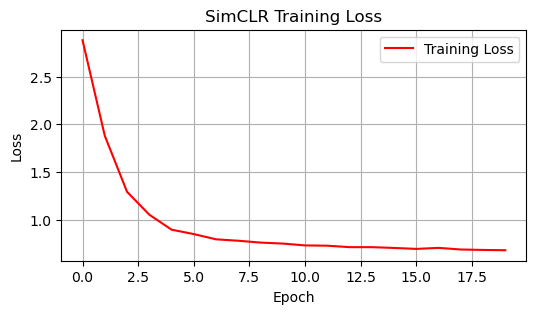

In [8]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(train_losses):
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(6, 3))

    # Plot loss curves
    ax.plot(train_losses, label="Training Loss", color="red")

    # Set title and labels
    ax.set_title("SimCLR Training Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True)
    ax.legend()
    plt.savefig('losses_epochs.pdf', bbox_inches='tight')
    # Show plot
    plt.show()


plot_loss_accuracy(losses_epochs)

In [ ]:
import struct
binary_losses = struct.pack('f'*len(losses_epochs), *losses_epochs)

with open('models_v6/losses_epochs.bin', 'wb') as f:
    f.write(binary_losses)

In [4]:
# model = torch.load('models_v6/model_round1.pt')
encoder = torch.load('models_v6/encoder_round1.pt')

In [55]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np


dataset_test = RSiMCCDataset() # recreate the initial dataset without augmentation
dataloader_test = DataLoader(dataset_test, batch_size=800, shuffle=True)


# Select some random datapoints from the dataset
data = next(dataloader_test.__iter__())
datapoints = data[0]
labels = data[1]

labels = np.argmax(labels, axis=1)


# Get the embeddings for the datapoints using your trained model
encoder.eval() # set the model to evaluation mode

if not next(encoder.parameters()).device.type.startswith('cuda'):
    encoder.to('cuda') # very long otherwise
datapoints = datapoints.to('cuda')
embeddings = encoder(datapoints)

embeddings = embeddings.to('cpu')

In [54]:
free_memory()

In [56]:

# Convert embeddings to numpy array
embeddings_numpy = embeddings.detach().numpy()
labels_numpy = labels.detach().numpy()
del embeddings
del labels



# Choose between PCA or t-SNE
method = 'tsne'

if method == 'pca':
    # Use PCA to reduce the dimensionality of the embeddings to 2D
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings_numpy)
elif method == 'tsne':
    # Use t-SNE to reduce the dimensionality of the embeddings to 2D
    tsne = TSNE(n_components=2, perplexity=20)
    embeddings_2d = tsne.fit_transform(embeddings_numpy)
else:
    print("Invalid method selected. Please choose 'pca' or 'tsne'.")


free_memory()

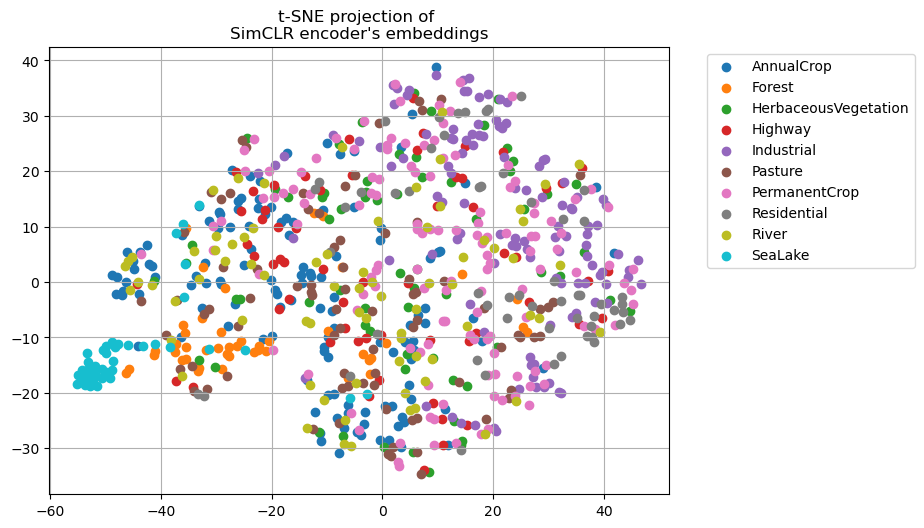

In [57]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the embeddings in 2D with each datapoint colored by its label
for i in range(len(dataset_test.classes)):
        plt.scatter(embeddings_2d[labels_numpy == i, 0], embeddings_2d[labels_numpy == i, 1])
    
    
plt.legend([str(i) for i in range(len(dataset_test.classes))])
# Add a legend to the plot
names = dataset_test.classes
plt.legend(labels=names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE projection of \nSimCLR encoder's embeddings")
plt.grid(True)
ax.set_aspect('equal', 'box')
plt.savefig('tsne.pdf', bbox_inches='tight')
plt.show()

In [56]:
embeddings_numpy.shape, labels_numpy.shape

((800, 32), (800,))

Text(37.597222222222214, 0.5, 'Embedding Dimension 2')

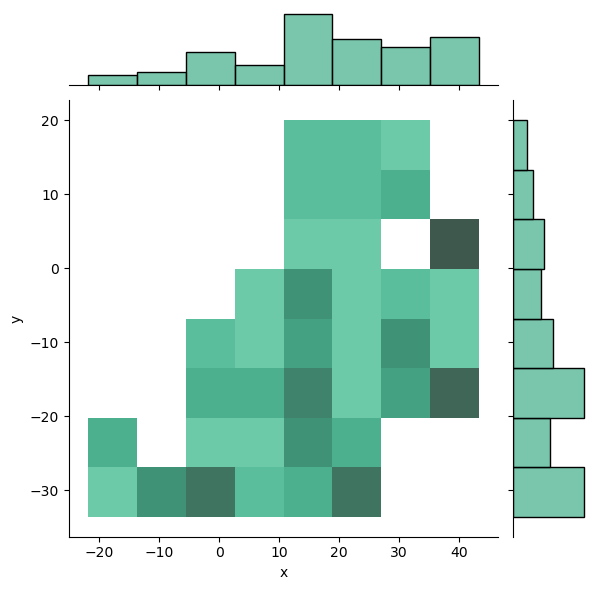

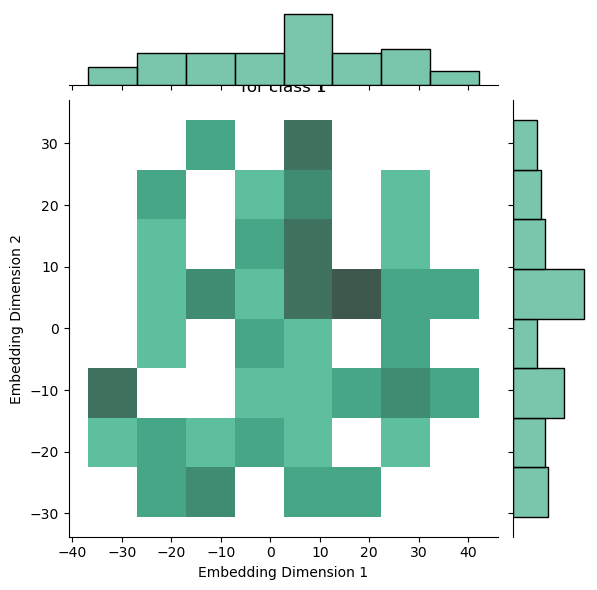

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

labels_name = [dataset_test.classes[lab] for lab in labels_numpy]
# Create a DataFrame with the embeddings and labels
data = pd.DataFrame({'x': embeddings_2d[:, 0], 'y': embeddings_2d[:, 1], 'label': labels_name})

category = 4
label = dataset_test.classes[category]
data_1 = data[data["label"] == label]

sns.jointplot(data=data_1, x='x', y='y', kind='hist', color="#4CB391")


category = 2
label = dataset_test.classes[category]
data_1 = data[data["label"] == label]

sns.jointplot(data=data_1, x='x', y='y', kind='hist', color="#4CB391")


# Add a title and axis labels
plt.title('2D Kernel Density Estimate Plot\nfor class 1')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')



In [36]:
label

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

/tmp/ipykernel_39288/3923861560.py:12: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.kdeplot(data=data_1, x='x', y='y', hue='label', alpha=.5, fill=False, palette=sns.color_palette("tab10"), levels=3)


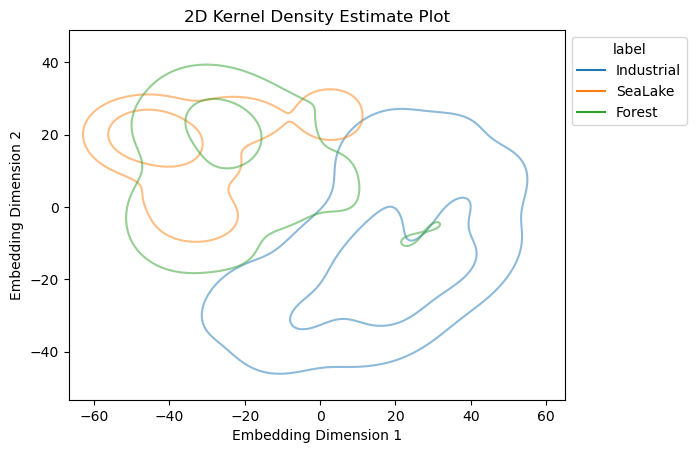

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

labels_name = [dataset_test.classes[lab] for lab in labels_numpy]
# Create a DataFrame with the embeddings and labels
data = pd.DataFrame({'x': embeddings_2d[:, 0], 'y': embeddings_2d[:, 1], 'label': labels_name})

data_1 = data[data["label"].isin(["Forest", "SeaLake", "Industrial"])]

# Create the KDE plot
ax = sns.kdeplot(data=data_1, x='x', y='y', hue='label', alpha=.5, fill=False, palette=sns.color_palette("tab10"), levels=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Add a title and axis labels
plt.title('2D Kernel Density Estimate Plot')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')

# Show the plot
plt.savefig('kde1.pdf', bbox_inches='tight')
plt.show()

In [39]:
dataset_test.classes[:5]

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial']

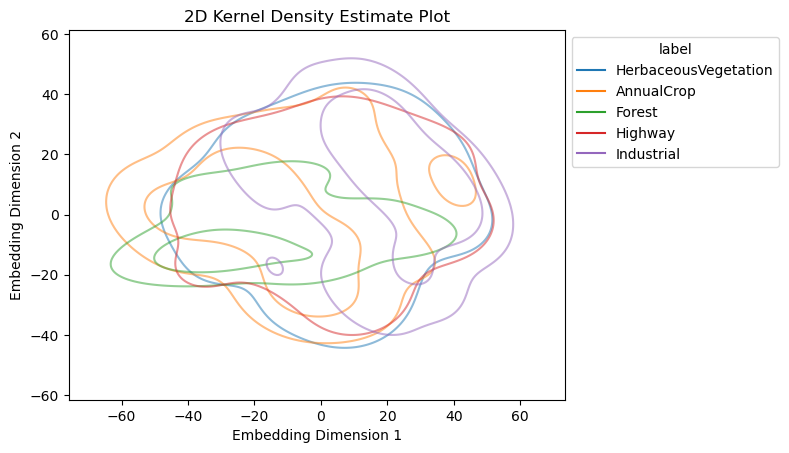

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

labels_name = [dataset_test.classes[lab] for lab in labels_numpy]
# Create a DataFrame with the embeddings and labels
data = pd.DataFrame({'x': embeddings_2d[:, 0], 'y': embeddings_2d[:, 1], 'label': labels_name})

data_1 = data[data["label"].isin(dataset_test.classes[:5])]

# Create the KDE plot
ax = sns.kdeplot(data=data_1, x='x', y='y', hue='label', alpha=.5, fill=False, palette=sns.color_palette("tab10")[:5], levels=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Add a title and axis labels
plt.title('2D Kernel Density Estimate Plot')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')

# Show the plot
plt.savefig('kde1.pdf', bbox_inches='tight')
plt.show()

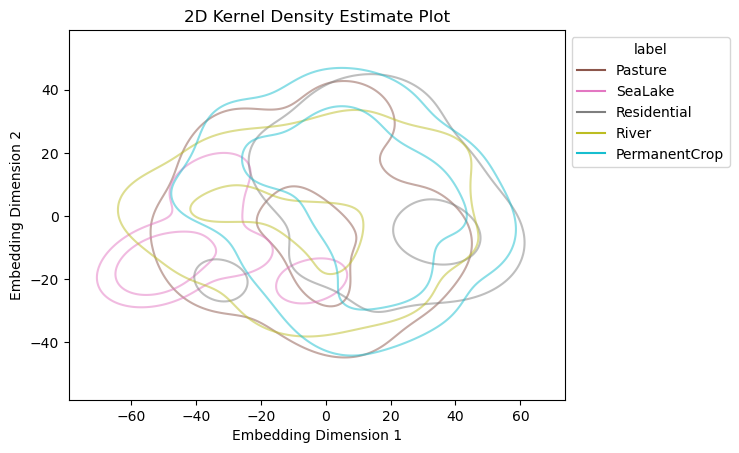

In [59]:
data_2 = data[data["label"].isin(dataset_test.classes[5:])]

# Create the KDE plot
ax = sns.kdeplot(data=data_2, x='x', y='y', hue='label', alpha=.5, fill=False, palette=sns.color_palette("tab10")[5:], levels=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Add a title and axis labels
plt.title('2D Kernel Density Estimate Plot')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')

# Show the plot
plt.savefig('kde2.pdf', bbox_inches='tight')
plt.show()

In [43]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [ ]:
data[data["label"] == "Residential"]

# Create the downstream network

### Initialize the model and dataloader

In [477]:
class ClassificationModel(nn.Module):
    def __init__(self, encoder, latent_dim=32, nb_classes=10):
        super(ClassificationModel, self).__init__()
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.projector = nn.Linear(latent_dim, nb_classes)
        self.bn = nn.BatchNorm1d(nb_classes)
        self.relu = nn.ReLU()

    def forward(self, x):        
        with torch.no_grad():
            x = self.encoder(x)
        
        x = self.projector(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [478]:
def get_classification_model(encoder, latent_dim=32, nb_classes=10):
    model = ClassificationModel(encoder, latent_dim, nb_classes)
    return model

In [479]:
classification_model = ClassificationModel(encoder, latent_dim=32, nb_classes=10) 
r = torch.rand(size=(42, 3, 64, 64))
classification_model.to('cpu')
classification_model(r).shape

torch.Size([42, 10])

In [480]:
summary(classification_model, input_size=(42, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
ClassificationModel                      [42, 10]                  --
├─Sequential: 1-1                        [42, 32]                  --
│    └─Conv2d: 2-1                       [42, 64, 57, 57]          (12,352)
│    └─BatchNorm2d: 2-2                  [42, 64, 57, 57]          (128)
│    └─ReLU: 2-3                         [42, 64, 57, 57]          --
│    └─Conv2d: 2-4                       [42, 64, 52, 52]          (147,520)
│    └─BatchNorm2d: 2-5                  [42, 64, 52, 52]          (128)
│    └─ReLU: 2-6                         [42, 64, 52, 52]          --
│    └─MaxPool2d: 2-7                    [42, 64, 26, 26]          --
│    └─Conv2d: 2-8                       [42, 64, 21, 21]          (147,520)
│    └─BatchNorm2d: 2-9                  [42, 64, 21, 21]          (128)
│    └─ReLU: 2-10                        [42, 64, 21, 21]          --
│    └─Conv2d: 2-11                      [42, 64, 17, 17

In [481]:
# Create training and validation datasets
from torch.utils.data import random_split



dataset = RSiMCCDataset()


batch_size = 128
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

data_loader = DataLoader(dataset, batch_size=100, shuffle=True)

train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


num_classes = len(dataset.classes)
model = get_classification_model(encoder, latent_dim=32, nb_classes=10)
# model.load_state_dict(torch.load("best_model.pt"))


criterion = torch.nn.CrossEntropyLoss() # CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


image = torch.randn(20, 3, 64, 64) # create dummy image
model.to('cpu')
output = model(image)

print(model(image).shape) # show the output of one batch of images

from torchinfo import summary
summary(model) # display summary of the model and number of trainable parameters

Feature batch shape: torch.Size([100, 3, 64, 64])
Labels batch shape: torch.Size([100, 10])
torch.Size([20, 10])


Layer (type:depth-idx)                   Param #
ClassificationModel                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (12,352)
│    └─BatchNorm2d: 2-2                  (128)
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       (147,520)
│    └─BatchNorm2d: 2-5                  (128)
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
│    └─Conv2d: 2-8                       (147,520)
│    └─BatchNorm2d: 2-9                  (128)
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      (102,464)
│    └─BatchNorm2d: 2-12                 (128)
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
│    └─Conv2d: 2-15                      (102,464)
│    └─BatchNorm2d: 2-16                 (128)
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2-18                      (32,800)
│    └─BatchNorm

### Send the model to the GPU

In [482]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ClassificationModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(8, 8), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(6, 6), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 64, kernel_size=(6, 6), stride=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (15): BatchNorm

### Define the training function

In [483]:
def train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        # Training
        running_loss = 0.0
        correct = 0
        total = 0
        for batch, (X, y) in enumerate(train_loader):
            # Move tensors to the configured device
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            # Compute prediction and loss
            pred = model(X)

            # Compute loss and its gradients
            loss = loss_fn(pred, y)
            loss.backward()
            

            # Backpropagation step
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(pred.data, 1)
            total += y.size(0)
            correct += (predicted == y.argmax(1)).sum().item()

            # Display progress
            if batch % 10 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"Epoch {epoch+1}, batch {batch+1}/{len(train_loader)}, loss: {loss:.4f}")
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}, train loss: {train_loss:.4f}, train accuracy: {train_acc:.2f}%")

        # Validation

        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch, (X, y) in enumerate(val_loader):
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss = loss_fn(pred, y)
                running_loss += loss.item()
                _, predicted = torch.max(pred.data, 1)
                total += y.size(0)
                correct += (predicted == y.argmax(1)).sum().item()
            val_loss = running_loss / len(val_loader)
            val_acc = 100 * correct / total
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            print(f"Epoch {epoch+1}, val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")
        
            # # Save best model
            # if val_acc > best_val_acc:
            #     best_val_acc = val_acc
            #     torch.save(model.state_dict(), "best_model.pt")

    return train_losses, train_accs, val_losses, val_accs



In [484]:
train_losses, train_accs, val_losses, val_accs = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=150)

Epoch 1, batch 1/72, loss: 2.5075
Epoch 1, batch 11/72, loss: 2.5931
Epoch 1, batch 21/72, loss: 2.5540
Epoch 1, batch 31/72, loss: 2.4674
Epoch 1, batch 41/72, loss: 2.4682
Epoch 1, batch 51/72, loss: 2.4042
Epoch 1, batch 61/72, loss: 2.4030
Epoch 1, batch 71/72, loss: 2.2355
Epoch 1, train loss: 2.4457, train accuracy: 10.81%
Epoch 1, val loss: 2.3155, val accuracy: 15.71%
Epoch 2, batch 1/72, loss: 2.2412
Epoch 2, batch 11/72, loss: 2.2565
Epoch 2, batch 21/72, loss: 2.2829
Epoch 2, batch 31/72, loss: 2.2791
Epoch 2, batch 41/72, loss: 2.2754
Epoch 2, batch 51/72, loss: 2.2291
Epoch 2, batch 61/72, loss: 2.1578
Epoch 2, batch 71/72, loss: 2.2594
Epoch 2, train loss: 2.2177, train accuracy: 21.07%
Epoch 2, val loss: 2.1326, val accuracy: 26.13%
Epoch 3, batch 1/72, loss: 2.1143
Epoch 3, batch 11/72, loss: 2.0863
Epoch 3, batch 21/72, loss: 2.1141
Epoch 3, batch 31/72, loss: 2.0722
Epoch 3, batch 41/72, loss: 2.1556
Epoch 3, batch 51/72, loss: 1.9716
Epoch 3, batch 61/72, loss: 2.109

KeyboardInterrupt: 

In [43]:
torch.save(model.state_dict(), "best_model_v5.pt")

In [375]:
import matplotlib.pyplot as plt

def plot_loss_accuracy2(train_losses, val_losses, train_accs, val_accs):
    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax2 = ax1.twinx()

    # Plot loss curves
    ax1.plot(train_losses, label="Training Loss", color="blue")
    ax1.plot(val_losses, label="Validation Loss", color="orange")

    
    

    # Plot accuracy curves
    ax2.plot(train_accs, label="Training Accuracy", color="green")
    ax2.plot(val_accs, label="Validation Accuracy", color="red")
    
    
    ax1.grid()
    ax2.grid()

    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper left")
    ax1.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend(loc="upper right")
    
    plt.show()

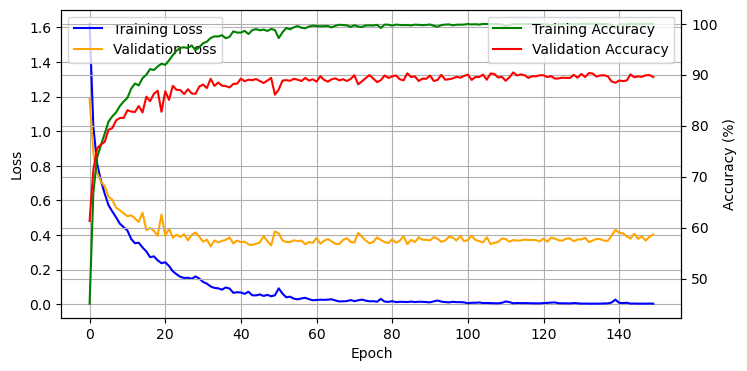

In [45]:
plot_loss_accuracy2(train_losses, val_losses, train_accs, val_accs)